In [56]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms 
from d2l import torch as d2l 

In [57]:
# 标签读取与创建小批量数据集
def get_fashion_mnist_labels(labels):
    text_labels = ['t_shirt', 'trouser', 'puller', 'dress', 'coat', 'sandal', 'shirt', 
                   'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

dataloader_workers = 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if(resize):
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data/3_6Softmax', train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data/3_6Softmax', train=False, transform=trans, download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, 
                            num_workers=dataloader_workers),
            data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=dataloader_workers))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# test
for X, y in train_iter:
    print(X.shape, y.shape)
    break

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [64]:
# 初始化参数与设定超参数
num_inputs = 28 * 28
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(10, requires_grad=True)

lr = 0.1 
# batch_size = 256

In [58]:
# 定义softmax
def softmax(X):
    X_exp = torch.exp(X)
    sum = X_exp.sum(1, keepdim=True)
    return X_exp / sum

In [59]:
# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [60]:
# 定义交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [61]:
# 优化方法
def sgd(params, learn_rate, batch_size):
    with torch.no_grad():
        for param in params:
            param -= learn_rate * param.grad / batch_size
            param.grad.zero_()

In [62]:
# 定义累加器
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [ ]:
# 分类精度
def accuracy(y_hat, y):
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [65]:
# 定义单次训练
def updater(batch_size):
    return sgd([W, b], lr, batch_size)

def train_epoch(net, train_iter, loss, updater):
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        l.sum().backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), X.shape[0])
    return metric[0] / metric[2], metric[1] / metric[2]

In [66]:
# 定义批量训练并可视化
def train(test_iter, train_iter, net, loss, updater, num_eqochs):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_eqochs], ylim=[0.3, 0.9],
                            legend=['train loss', 'train acc', 'test acc'])
    for eqoch in range(num_eqochs):
        train_metric = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(eqoch + 1, train_metric + (test_acc,))

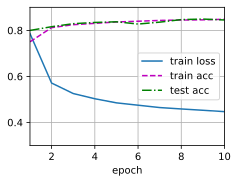

In [67]:
num_eqochs = 10
train(test_iter, train_iter, net, cross_entropy, updater, num_eqochs)

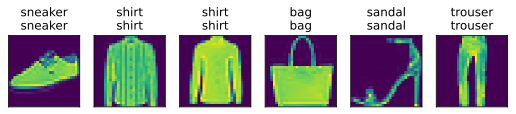

In [68]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape(n, 28, 28), 1, n, titles)

predict(net, test_iter)